In [19]:
import pandas as pd

data = pd.read_csv("out/small.dump.csv", sep=";")
data.head()

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
0,0.0,11,11_0,11_550.qPKW.0.0,44.29,27.27
1,0.0,11,11_0,11_696.qPKW.0.0,57.94,30.80
2,0.0,11,11_1,11_857.qPKW.0.0,57.94,31.46
3,0.0,11,11_2,11_377.qPKW.0.0,57.94,29.94
4,0.0,11,11_3,NaN,NaN,NaN


In [20]:
# data = data.drop(data[data["edge_id"].isna()].index.values)
data = data.dropna(subset=["edge_id", "vehicle_id"])

In [22]:
data = data.drop(data[data.edge_id.str.startswith(':')].index.values)
data.head()

,timestep_time,edge_id,lane_id,vehicle_id,vehicle_pos,vehicle_speed
0,0.0,11,11_0,11_550.qPKW.0.0,44.29,27.27
1,0.0,11,11_0,11_696.qPKW.0.0,57.94,30.80
2,0.0,11,11_1,11_857.qPKW.0.0,57.94,31.46
3,0.0,11,11_2,11_377.qPKW.0.0,57.94,29.94
5,0.0,1148,1148_0,1148_856.qPKW.0.0,12.79,24.15


In [24]:
data["vehicle_id"].nunique()

13457

In [ ]:
# data["vehicle_id"] = data["vehicle_id"].fillna(0).apply(lambda x: 1 if x != 0 else 0)
# data.head()

In [5]:
overall = data.groupby(["edge_id", "vehicle_id"]).agg({'vehicle_speed': 'mean'}).reset_index()
overall = overall.groupby(["edge_id"]).agg({'vehicle_id':'count', 'vehicle_speed': 'mean'})
overall = overall.rename(columns={"vehicle_id": "flow"}).reset_index()
overall["edge_id"] = pd.to_numeric(overall["edge_id"])
overall.head()

,edge_id,flow,vehicle_speed
0,1,1493,27.520085
1,10,1112,26.173898
2,1000,60,28.247333
3,1002,412,2.744086
4,1004,1233,12.351339


In [ ]:
# overall = data.groupby(["edge_id"]).agg({'vehicle_id':'nunique', 'vehicle_speed':['mean', 'count']}).reset_index()
# overall = overall.rename(columns={"vehicle_id": "flow"})
# overall["edge_id"] = pd.to_numeric(overall["edge_id"])
# overall.head()

In [7]:
covered_edges = overall["edge_id"].unique()

for i in range(1220):
    if i not in covered_edges:
        overall.loc[len(overall.index)] = [i, 0, 0.0]
        
overall["edge_id"].nunique()

1220

In [8]:
edgelist = pd.read_csv("out/small.edges.csv", sep=";")
edgelist.head()

,edge_from,edge_id,edge_length,edge_numLanes,edge_speed,edge_to
0,1614922744,0,23.141939,2,29.0576,1614922747
1,269459339,1,60.826398,5,29.0576,269459341
2,1621320618,2,109.464966,2,29.0576,1621320622
3,269459229,3,160.720645,3,29.0576,269459230
4,607954833,4,173.017706,3,29.0576,1613371666


In [9]:
edgelist = pd.merge(edgelist, overall, on="edge_id")

ordered_cols = ["edge_id", "edge_from", "edge_to", "edge_length", "edge_numLanes", "edge_speed", "flow", "vehicle_speed"]
edgelist = edgelist[ordered_cols]

edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.000000
1,1,269459339,269459341,60.826398,5,29.0576,1493.0,27.520085
2,2,1621320618,1621320622,109.464966,2,29.0576,0.0,0.000000
3,3,269459229,269459230,160.720645,3,29.0576,696.0,22.966150
4,4,607954833,1613371666,173.017706,3,29.0576,1609.0,12.105091


In [10]:
edgelist["flow"].nunique()

446

In [11]:
(edgelist["flow"] == 0).sum()

483

In [13]:
edgelist.to_csv("out/small.results.csv", index=False)

In [14]:
nodes = pd.read_csv("out/small.nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


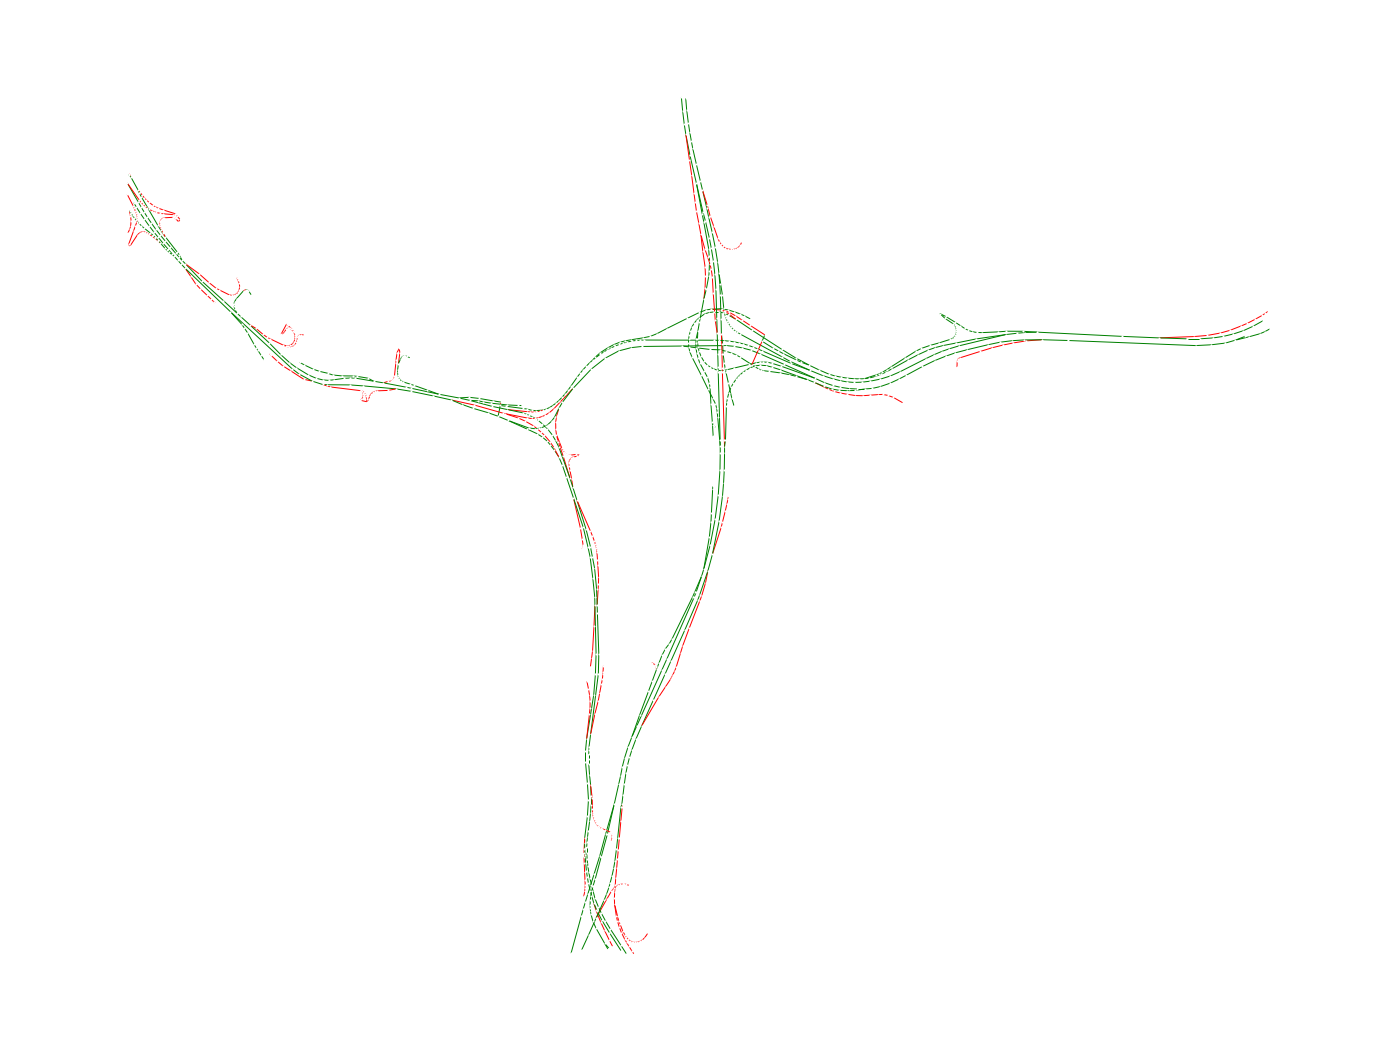

In [15]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
nx.set_node_attributes(G, nodes.to_dict("index"))

edge_colors = ["red" if G[u][v]["flow"] == 0 else "green" for u,v in G.edges]
# edge_colors = [cmap(G[u][v]["flow"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

In [25]:
import pickle 
import numpy as np

with open('data/small_speeds.pkl', 'rb') as f:
    speeds = pickle.load(f)

with open('data/small_flows.pkl', 'rb') as f:
    flows = pickle.load(f)

for u, v in G.edges:
    key = (str(u), str(v))
    try:
        err = (flows[key] - G[u][v]["flow"])
    except KeyError:
        err = 0
        
    if err != 0:
        print(u, v, flows[key], G[u][v]["flow"])
    G[u][v]["err"] = err

269459341 269459342 4744.8544354378355 1490.0
269459230 269459231 2912.1792442059595 594.0
363433967 72602888 513.3680555555555 0.0
268539762 20972371 3997.3967803030305 1764.0
1614922929 268539761 374.99138332557055 0.0
268537917 268537918 4999.955131864368 3365.0
807592312 1614922953 1347.3463541666667 244.0
1614922742 1614922738 190.07737801872844 1152.0
269460527 269460939 3167.9422308482704 1122.0
269460920 353033055 5469.434981162233 2344.0
1347515636 268538952 3929.2595238095237 863.0
1613371763 1613371771 2363.6783879438294 776.0
1613371775 1613371776 5618.16120561708 2310.0
269459401 269459402 190.82601530311948 0.0
1621320600 269461330 230.6904296875 935.0
38454761 1832222751 3546.3933097385548 1163.0
269459231 269459232 2652.696426532709 579.0
653786 1613371774 5128.9810480648475 2327.0
1613371720 1613371701 4917.951592647562 1388.0
269460896 269460897 312.1148539465506 939.0
35361362 319435660 4384.524717433497 2448.0
268537923 353034879 5033.313163603151 3050.0
6876014919 

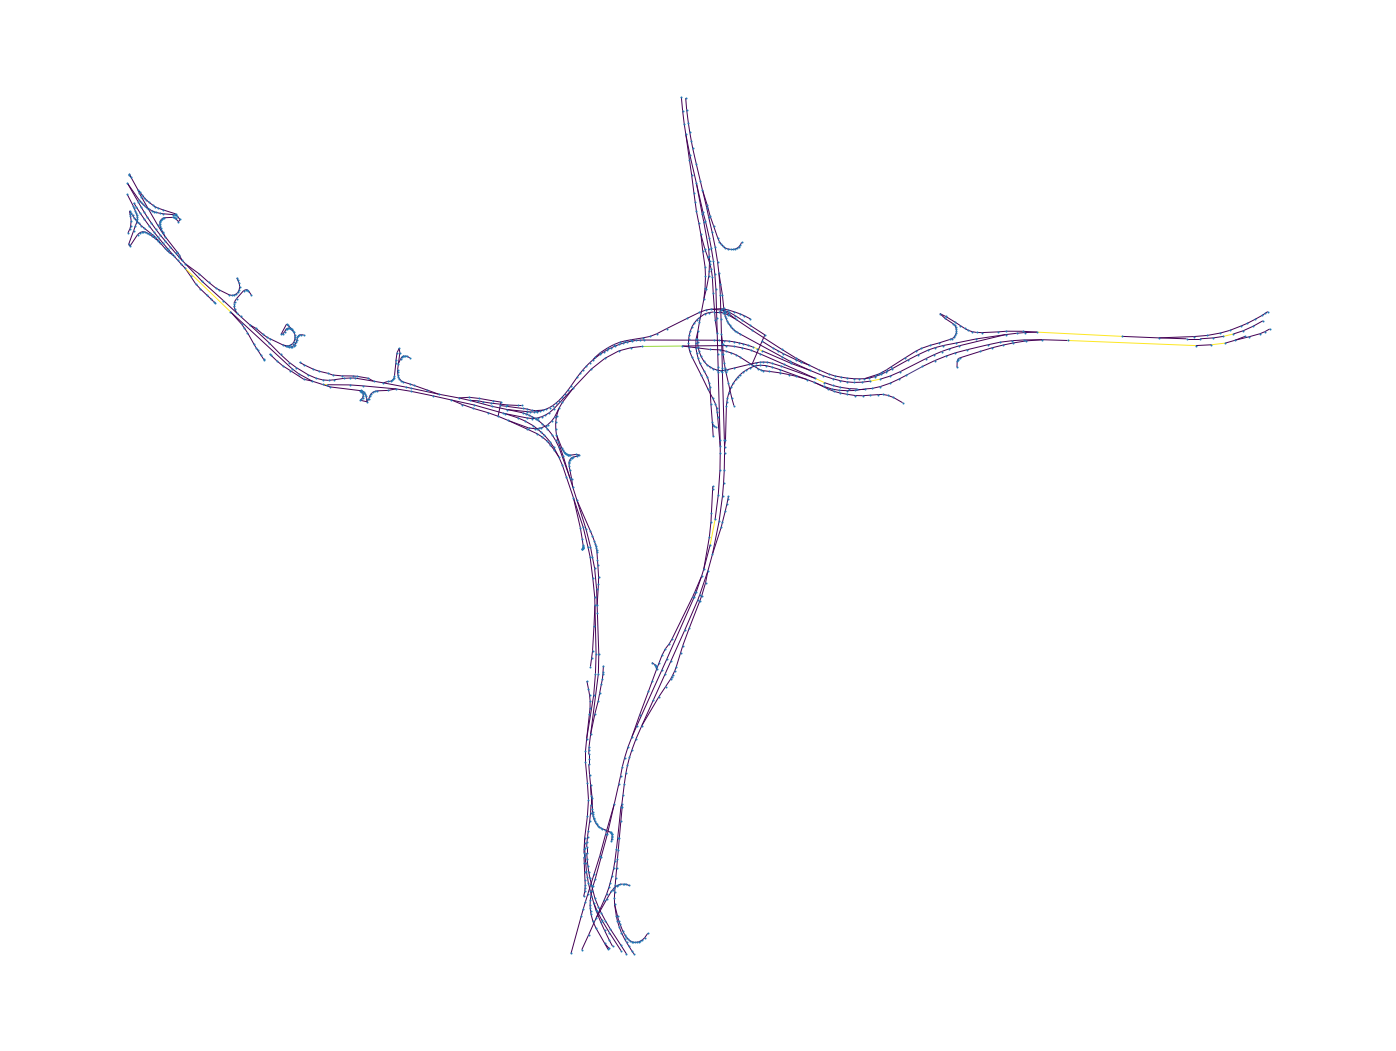

In [18]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, pos=positions, node_size=1, edge_color=[cmap(G[u][v]["err"]) for u, v in G.edges])
plt.show()

In [ ]:
plt.hist([G[u][v]["flow"] for u,v in G.edges])

In [ ]:
plt.hist(data["vehicle_speed"])